In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns

In [3]:
#Importing Data
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
#Removing Null Values
data_dropped = data.dropna(axis=0)

In [4]:
#Removing id column
data_updated = data_dropped.drop("id", axis=1)

#Changining categorical data into indicators
gender = pd.get_dummies(data_updated.gender)
gender = gender.rename(columns = {1: "Male", 2:"Female", 3: "Other"})

ever_married = pd.get_dummies(data_updated.ever_married)
ever_married = ever_married.rename(columns = {"No":"Never_Married", "Yes":"Ever_Married"})

work_type = pd.get_dummies(data_updated.work_type)
work_type=work_type.rename(columns = {1: "children", 2:"Govt_job", 3:"Never_worked", 4:"Private", "Self-employed":"Self_employed"})

Residence_type = pd.get_dummies(data_updated.Residence_type)
Residence_type=Residence_type.rename(columns = {1: "Urban", 2:"Rural"})

smoking_status = pd.get_dummies(data_updated.smoking_status)
smoking_status=smoking_status.rename(columns = {"formerly smoked": "formerly_smoked", "never smoked":"never_smoked", 3:"smokes", 4:"unknown"})

#Adding indicators to dataframe and dropping redundent columns
data_indicators = pd.concat([gender, ever_married, work_type, Residence_type, 
                             smoking_status, data_updated], axis=1).drop(['gender', 'ever_married', 'work_type', 
                            'Other', 'Never_Married', 'Rural', 'Residence_type', 'smoking_status'], axis=1)

C:\Users\jakem\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


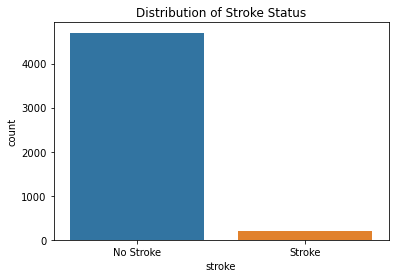

In [5]:
g = sns.countplot(data_indicators['stroke'])
g.set_xticklabels(['No Stroke','Stroke'])
plt.title('Distribution of Stroke Status')
plt.show()

In [6]:
data_indicators = data_indicators.sample(frac = 1, random_state=1)
training, testing = np.split(data_indicators, [int(.8*len(data_indicators))])

In [7]:
class_1 = training[training['stroke'] == 1]
class_1_over = class_1.sample(round(22*len(class_1)), replace = True)
training = training.append([class_1_over])
training['stroke'].value_counts()

1    3841
0    3760
Name: stroke, dtype: int64

In [8]:
x_train = training.drop(['stroke'], axis=1)
y_train = training['stroke']
x_test = testing.drop(['stroke'], axis=1)
y_test = testing['stroke']

C:\Users\jakem\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


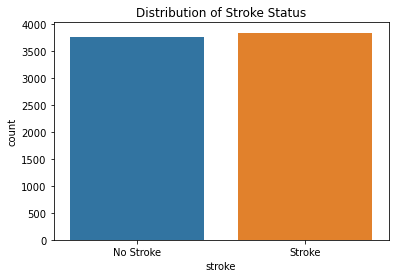

In [9]:
g = sns.countplot(training['stroke'])
g.set_xticklabels(['No Stroke','Stroke'])
plt.title('Distribution of Stroke Status')
plt.show()

In [9]:
#Creating Logisitc Regression Model
model=sm.Logit(y_train, sm.add_constant(x_train))
lr = model.fit(maxiter=100)
p_pred = lr.predict(sm.add_constant(x_test))
y_pred = np.round(p_pred)
print(lr.summary())

         Current function value: 0.471091
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 7601
Model:                          Logit   Df Residuals:                     7584
Method:                           MLE   Df Model:                           16
Date:                Mon, 18 Apr 2022   Pseudo R-squ.:                  0.3203
Time:                        20:43:32   Log-Likelihood:                -3580.8
converged:                      False   LL-Null:                       -5268.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -18.2117   3.12e+05  -5.84e-05      1.000   -6.12e+05    6.12e+05
Female               17.8223   2.82e+04    

C:\Users\jakem\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
print(metrics.accuracy_score(y_test, y_pred))
CM = metrics.confusion_matrix(y_test, y_pred)
print(CM)

TP = CM[1,1]
FP = CM[0,1]
TN = CM[0,0]
FN = CM[1,0]
TOT = TP + FN + FP + TN
 
MR = (FP + FN) / TOT
TPR = TP / (TP + FN)
TNR = TN / (FP + TN)
FPR = FP / (FP + TN)
FNR = FN / (TP + FN)

print('MR = ', MR)
print('TPR = ', TPR)
print('TNR = ', TNR)
print('FPR = ', FPR)
print('FNR = ',FNR)

0.7240325865580448
[[678 262]
 [  9  33]]
MR =  0.2759674134419552
TPR =  0.7857142857142857
TNR =  0.7212765957446808
FPR =  0.27872340425531916
FNR =  0.21428571428571427


Text(0, 0.5, 'True Positive Rate')

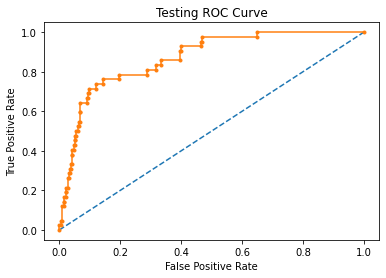

In [40]:
p_pred = lr.predict(sm.add_constant(x_test))
mr_probs = [0 for _ in range(len(y_test))]
mr_fpr, mr_tpr, _ = roc_curve(y_test, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, p_pred)
plt.plot(mr_fpr, mr_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.title('Testing ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.savefig('testing roc curve.png');

In [12]:
print("AUC:", metrics.auc(lr_fpr,lr_tpr))

AUC: 0.8703900709219857


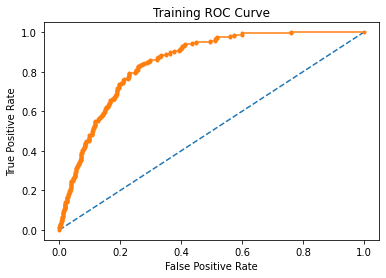

In [41]:
p_pred = lr.predict(sm.add_constant(x_train))
mr_probs = [0 for _ in range(len(y_train))]
mr_fpr, mr_tpr, _ = roc_curve(y_train, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_train, p_pred)
plt.plot(mr_fpr, mr_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.title('Training ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('testing roc curve.png');

In [14]:
print("AUC:", metrics.auc(lr_fpr,lr_tpr))

AUC: 0.8480957142144943


# LASSO Regression

In [10]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
lasso = LogisticRegressionCV(penalty='l1', solver='liblinear',scoring="neg_log_loss", cv=10, random_state=0)
lasso.fit(x_train, y_train)
pd.Series(lasso.coef_.reshape(18,), index=data_indicators.iloc[:,0:18].columns)

Female               0.081184
Male                 0.053398
Ever_Married         0.046154
Govt_job            -0.042099
Never_worked        -0.309337
Private              0.030403
Self_employed       -0.072059
children             0.274297
Urban                0.072785
Unknown             -0.254614
formerly_smoked     -0.176862
never_smoked        -0.265692
smokes               0.003431
age                  1.695996
hypertension         0.287606
heart_disease        0.083039
avg_glucose_level    0.206832
bmi                  0.059642
dtype: float64

In [11]:
y_pred = lasso.predict(x_test)

In [12]:
print("Accuracy Score: ", metrics.accuracy_score(y_test, y_pred))
CM = metrics.confusion_matrix(y_test, y_pred)
print(CM)

TP = CM[1,1]
FP = CM[0,1]
TN = CM[0,0]
FN = CM[1,0]
TOT = TP + FN + FP + TN
 
MR = (FP + FN) / TOT
TPR = TP / (TP + FN)
TNR = TN / (FP + TN)
FPR = FP / (FP + TN)
FNR = FN / (TP + FN)

print('MR = ', MR)
print('TPR = ', TPR)
print('TNR = ', TNR)
print('FPR = ', FPR)
print('FNR = ',FNR)

Accuracy Score:  0.7169042769857433
[[671 269]
 [  9  33]]
MR =  0.2830957230142566
TPR =  0.7857142857142857
TNR =  0.7138297872340426
FPR =  0.28617021276595744
FNR =  0.21428571428571427


# K-Nearest Neighbor

Training - Testing Validation

In [18]:
accuracy = []
for k in range(1, 21):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(x_train, y_train)
    pred_k = classifier.predict(x_test)
    accuracy.append(metrics.accuracy_score(y_test, pred_k))

Text(0, 0.5, 'accuracy score')

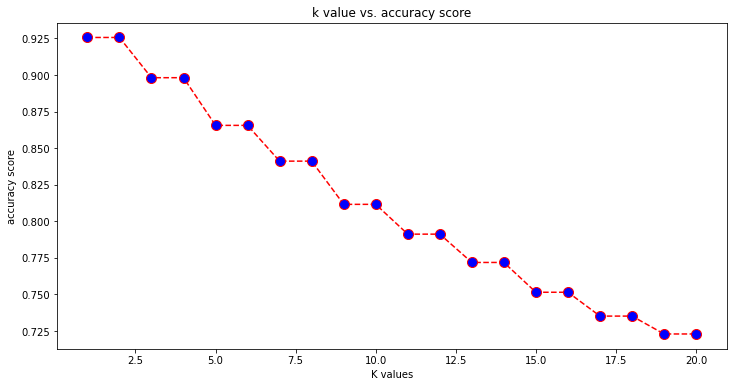

In [19]:
plt.figure(figsize=(12,6))
plt.plot(range(1,21), accuracy, color='red', linestyle='dashed', marker = 'o', markerfacecolor='blue', markersize=10)
plt.title('k value vs. accuracy score')
plt.xlabel('K values')
plt.ylabel('accuracy score')

In [20]:
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(x_train, y_train)
pred_k = classifier.predict(x_test)
print("Accuracy Score: ", metrics.accuracy_score(y_test, pred_k))
print(metrics.confusion_matrix(y_test, pred_k))

Accuracy Score:  0.9256619144602851
[[906  34]
 [ 39   3]]


In [21]:
CM = metrics.confusion_matrix(y_test, pred_k)
print(CM)

TP = CM[1,1]
FP = CM[0,1]
TN = CM[0,0]
FN = CM[1,0]
TOT = TP + FN + FP + TN
 
MR = (FP + FN) / TOT
TPR = TP / (TP + FN)
TNR = TN / (FP + TN)
FPR = FP / (FP + TN)
FNR = FN / (TP + FN)

print('MR = ', MR)
print('TPR = ', TPR)
print('TNR = ', TNR)
print('FPR = ', FPR)
print('FNR = ',FNR)

[[906  34]
 [ 39   3]]
MR =  0.07433808553971487
TPR =  0.07142857142857142
TNR =  0.9638297872340426
FPR =  0.036170212765957444
FNR =  0.9285714285714286


Cross Validation

In [22]:
cv_score = []
for k in range(1,20):
    classifier = KNeighborsClassifier(n_neighbors=k)
    cv = cross_val_score(classifier, x_train, y_train, cv=5)
    cv_score.append(np.mean(cv))

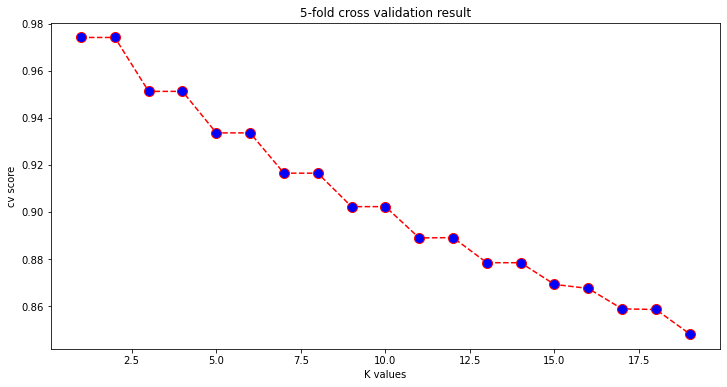

In [23]:
plt.figure(figsize=(12,6))
plt.plot(range(1,20),cv_score, color='red', linestyle='dashed', marker = 'o', 
         markerfacecolor='blue', markersize=10)
plt.title('5-fold cross validation result')
plt.xlabel('K values')
plt.ylabel('cv score');

In [24]:
classifier = KNeighborsClassifier(n_neighbors=2)
cv = cross_val_score(classifier, x_train, y_train, cv=5)
print("Average Accuracy Score:", np.mean(cv))

Average Accuracy Score: 0.974082148171217


In [25]:
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

0.9256619144602851
[[906  34]
 [ 39   3]]


In [26]:
CM = metrics.confusion_matrix(y_test, y_pred)
print(CM)

TP = CM[1,1]
FP = CM[0,1]
TN = CM[0,0]
FN = CM[1,0]
TOT = TP + FN + FP + TN
 
MR = (FP + FN) / TOT
TPR = TP / (TP + FN)
TNR = TN / (FP + TN)
FPR = FP / (FP + TN)
FNR = FN / (FP + FN)

print('MR = ', MR)
print('TPR = ', TPR)
print('TNR = ', TNR)
print('FPR = ', FPR)
print('FNR = ',FNR)

[[906  34]
 [ 39   3]]
MR =  0.07433808553971487
TPR =  0.07142857142857142
TNR =  0.9638297872340426
FPR =  0.036170212765957444
FNR =  0.5342465753424658


# Decision Tree

In [20]:
x_train = training.drop(['stroke'], axis=1)
y_train = training['stroke']
x_test = testing.drop(['stroke'], axis=1)
y_test = testing['stroke']

In [21]:
tree1 = DecisionTreeClassifier(random_state=0)
tree1.fit(x_train, y_train)
pred_test = tree1.predict(x_test)
print("Test accuracy:",metrics.accuracy_score(pred_test,y_test))

Test accuracy: 0.9226069246435845


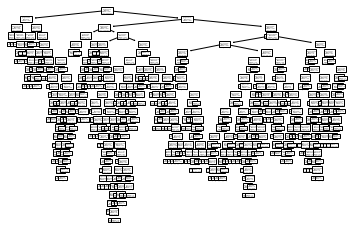

In [22]:
plot_tree(tree1);

In [23]:
CM = metrics.confusion_matrix(y_test, pred_test)
print(CM)

TP = CM[1,1]
FP = CM[0,1]
TN = CM[0,0]
FN = CM[1,0]
TOT = TP + FN + FP + TN
 
MR = (FP + FN) / TOT
TPR = TP / (TP + FN)
TNR = TN / (FP + TN)
FPR = FP / (FP + TN)
FNR = FN / (FP + FN)

print('MR = ', MR)
print('TPR = ', TPR)
print('TNR = ', TNR)
print('FPR = ', FPR)
print('FNR = ',FNR)

[[900  40]
 [ 36   6]]
MR =  0.07739307535641547
TPR =  0.14285714285714285
TNR =  0.9574468085106383
FPR =  0.0425531914893617
FNR =  0.47368421052631576


AUC: 0.5501519756838905


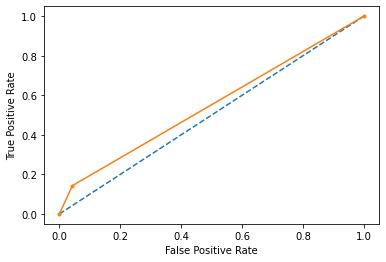

In [24]:
pred_test_prob = tree1.predict_proba(x_test)
mr_probs = [0 for _ in range(len(y_test))]
mr_fpr, mr_tpr, _ = roc_curve(y_test, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_test_prob[:,1])
plt.plot(mr_fpr, mr_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("AUC:",metrics.auc(lr_fpr, lr_tpr))
#plt.savefig('NoncpROC.png');

In [25]:
tree = DecisionTreeClassifier(random_state=0)
path = tree.cost_complexity_pruning_path(x_train,y_train)
alphas, impurities = path.ccp_alphas, path.impurities
cv_score = []
for i in alphas:
    tree1 = DecisionTreeClassifier(random_state=0, ccp_alpha = i)
    cv = cross_val_score(tree1, x_train, y_train, cv=10, scoring = 'accuracy')
    cv_score.append(np.mean(cv))

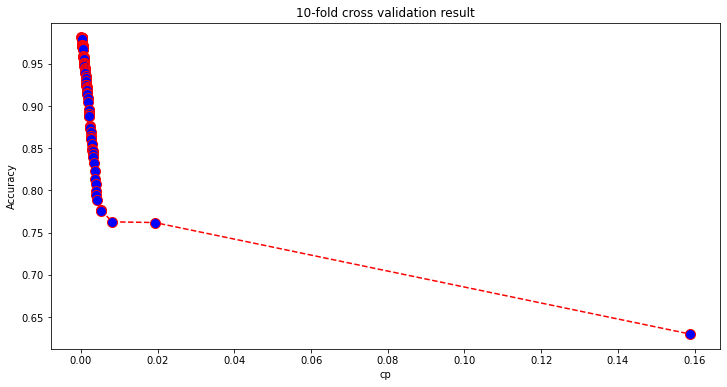

In [26]:
plt.figure(figsize=(12,6))
plt.plot(alphas,cv_score,color='red',linestyle='dashed',marker='o',
        markerfacecolor='blue',markersize=10)
plt.title('10-fold cross validation result')
plt.xlabel('cp')
plt.ylabel('Accuracy');

In [27]:
alphas[np.argmax(cv_score)]

0.0

In [28]:
tree2 = DecisionTreeClassifier(random_state=0, ccp_alpha = alphas[np.argmax(cv_score)])
tree2.fit(x_train, y_train)
pred_test = tree2.predict(x_test)
print("Test accuracy:",metrics.accuracy_score(pred_test,y_test))

Test accuracy: 0.9226069246435845


In [29]:
CM = metrics.confusion_matrix(y_test, pred_test)
print(CM)

TP = CM[1,1]
FP = CM[0,1]
TN = CM[0,0]
FN = CM[1,0]
TOT = TP + FN + FP + TN
 
MR = (FP + FN) / TOT
TPR = TP / (TP + FN)
TNR = TN / (FP + TN)
FPR = FP / (FP + TN)
FNR = FN / (FP + FN)

print('MR = ', MR)
print('TPR = ', TPR)
print('TNR = ', TNR)
print('FPR = ', FPR)
print('FNR = ',FNR)

[[900  40]
 [ 36   6]]
MR =  0.07739307535641547
TPR =  0.14285714285714285
TNR =  0.9574468085106383
FPR =  0.0425531914893617
FNR =  0.47368421052631576


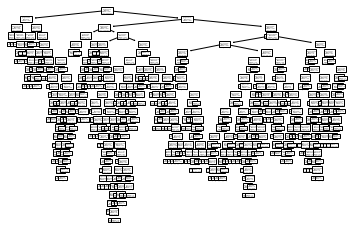

In [30]:
plot_tree(tree2);